In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import os.path
from PIL import Image


2024-06-15 16:50:56.134878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 16:50:56.135103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 16:50:56.296723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

**Load dataset**

In [4]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train',batch_size=64,image_size=(32,32))

Found 100000 files belonging to 2 classes.


In [5]:
data_itr = data.as_numpy_iterator()

In [6]:
batch = data_itr.next()
batch[0].shape

(64, 32, 32, 3)

In [7]:
batch[1]

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1],
      dtype=int32)

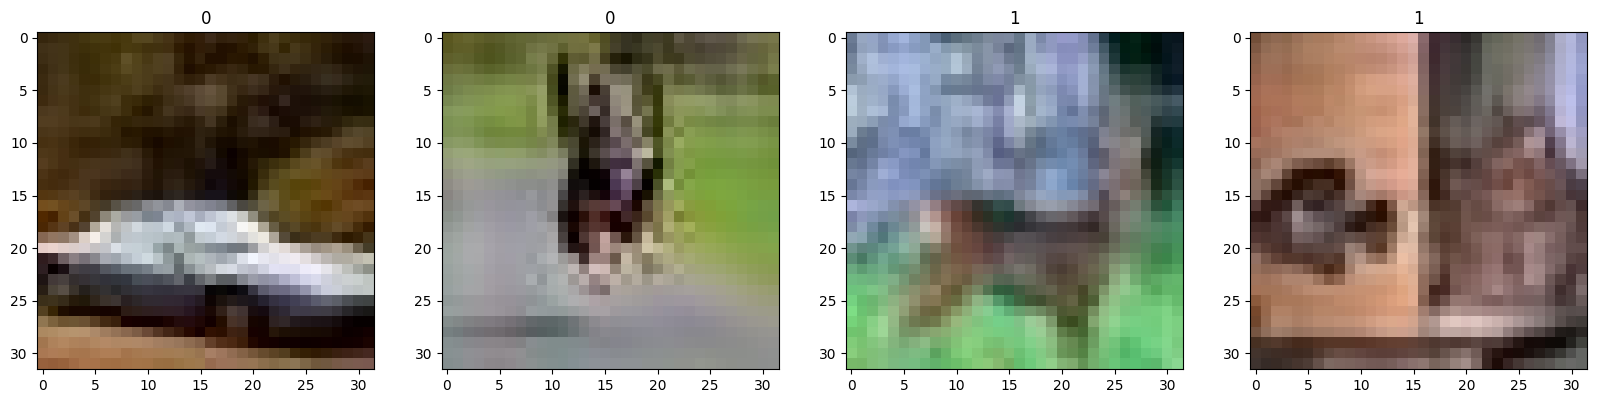

In [8]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**Preprocess Data**

In [9]:
data = data.map(lambda x,y:(x/255,y))

In [10]:
scaled_itr = data.as_numpy_iterator()
batch = scaled_itr.next()

In [11]:
batch[0].shape

(64, 32, 32, 3)

**Splitting data**

In [12]:
len(data)

1563

In [13]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [14]:
train_size+val_size+test_size

1563

In [15]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)
val = data.skip(train_size+test_size).take(val_size)

**Deep learning model**

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.python.keras import regularizers

In [17]:
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,833 (878.25 KB)

 Trainable params: 224,833 (878.25 KB)

 Non-trainable params: 0 (0.00 B)

**Train**

In [18]:
hist = model.fit(train,
                 epochs = 50,
                validation_data = val)

Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 115s 103ms/step - accuracy: 0.7568 - loss: 0.8653 - val_accuracy: 0.8667 - val_loss: 0.3312
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 66s 61ms/step - accuracy: 0.8665 - loss: 0.3317 - val_accuracy: 0.8735 - val_loss: 0.3311
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 65s 60ms/step - accuracy: 0.8899 - loss: 0.2849 - val_accuracy: 0.9074 - val_loss: 0.2511
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.9058 - loss: 0.2517 - val_accuracy: 0.9105 - val_loss: 0.2393
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9095 - loss: 0.2382 - val_accuracy: 0.9187 - val_loss: 0.2207
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 64s 59ms/step - accuracy: 0.9180 - loss: 0.2237 - val_accuracy: 0.9046 - val_loss: 0.2521
Epoch 7/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 65s 59ms/step - accuracy: 0.9215 - loss: 0.2123 - val_accuracy: 0.9258 - val_loss: 0.2059
Epoch 8/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 65s 60ms/step - accuracy: 0.9298

**Plot performance**

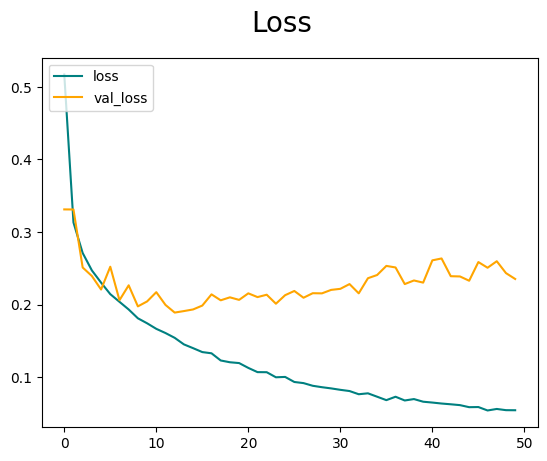

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

**Saving model**

In [20]:
import pickle
filename = "trained_model.sav"
pickle.dump(model, open(filename, 'wb'))

In [21]:
from tensorflow.keras.models import load_model

In [22]:
model.save(os.path.join('models','Imageclassifier.h5'))